Model: Human Activity Recognition using Conv,Slim LSTMs
7352 rows of data with 128 observation points.
Further Layers in Model: 3 Convnet1D()layers, Maxpooling, Dense along with globalnormalization layer along with slim LSTM layers with 3, 6 layers in Model.
Hyper parameters:loss Function used :'categorical_crossentropy', optimizer=adam batch_size=64, epochs=20. 
Efficiency: 90%

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Train data: (7352, 128, 9)
Test data: (2947, 128, 9)
Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 9)       0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 126, 64)      1792        input_9[0][0]                    
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 124, 64)      12352       conv1d_17[0][0]                  
__________________________________________________________________________________________________
dropout_34 (Dropout)            (None, 124, 64)      0           conv1d_18[0][0]        

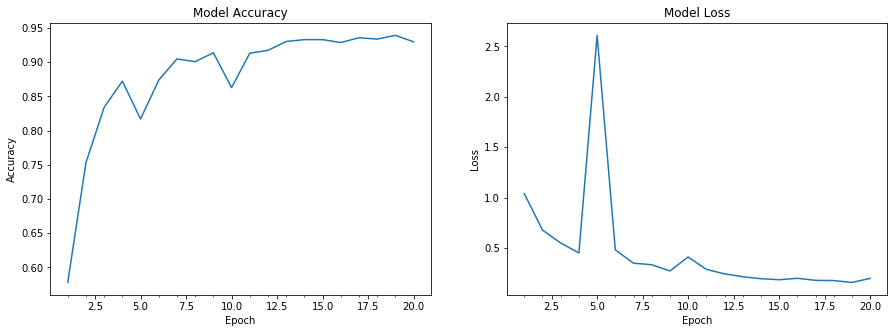

>#1: 90.227
[90.22734761238098]
Accuracy of the system: 90.227% (+/-0.000)


In [9]:
# cnn lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import keras 
import numpy as np
import os
import sys
import pdb
import keras.backend as K
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Embedding, Concatenate
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,Input
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

#from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPool2D, Dropout, TimeDistributed, LSTM, Input, Concatenate
from keras.optimizers import RMSprop, SGD, Adam ,Adadelta
acts = ['sigmoid' , 'tanh', 'softmax']

from slim21 import LSTMs

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
hidden_units = 400
lstms = ['LSTM3','LSTM11']
names = ['lstm3', 'lstm11']

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/UCI/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/UCI/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
#	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	print('Train data:', trainX.shape)
	print('Test data:', testX.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 0, 20, 64
	lstms = ['LSTM3','LSTM11']
	names = ['lstm3', 'lstm11']
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape data into time steps of sub-sequences
	n_steps, n_length = 4, 32
#	trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
#	testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
	# define model
#	sequence_input = Input(shape= (trainX.shape[0],))
	for cnt, lstm in enumerate(lstms):
		np.random.seed(3)
        
#		model = Sequential()
		sequence_input = Input(shape=(trainX.shape[1], n_features))
		lstmi = LSTMs(implementation= 1, units=hidden_units,
                activation='relu',
                    input_shape=trainX.shape[1:], model=lstm)
		x1 = lstmi(sequence_input)
		x1 = Dropout(.2)(x1)
		x2 = Conv1D(filters=64, kernel_size=3, activation='relu')(sequence_input)
		x2 = (Conv1D(filters=64, kernel_size=3, activation='relu'))(x2)
		x2 = Dropout(0.25)(x2)
		x2 = MaxPooling1D(pool_size=2)(x2)
		x2 = Flatten()(x2)
		x2 = Dropout(0.25)(x2)
		x2 = Dense(100, activation='relu')(x2)
		x2 = Dense(n_outputs, activation='softmax')(x2)
		conc = keras.layers.Concatenate()([x1, x2])
		x = Dropout(0.20)(conc)
		preds = Dense(6, activation='softmax')(x)
		model = Model(sequence_input, preds)
		summ=model.summary() 
		model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
        # fit network
		history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=1)
        # evaluate model
		_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
		plot_model_history(history)
		return accuracy

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    plt.show()
    

#summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy of the system: %.3f%% (+/-%.3f)' % (m, s))


#run an experiment
def run_experiment(repeats=1):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
 #run the experiment
run_experiment()

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
Train data: (7352, 128, 9)
Test data: (2947, 128, 9)
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, 128, 9)       0                                            
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 126, 64)      1792        input_11[0][0]                   
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 124, 64)      12352       conv1d_21[0][0]                  
__________________________________________________________________________________________________
dropout_42 (Dropout)            (None, 124, 64)      0           conv1d_22[0][0]       

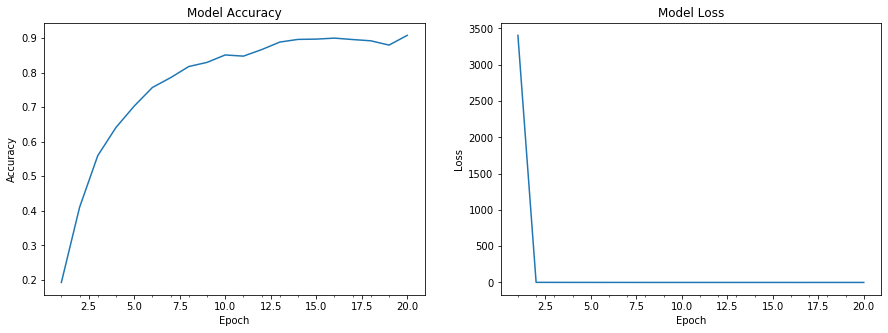

>#1: 87.852
[87.85205483436584]
Accuracy of the system: 87.852% (+/-0.000)


In [11]:
# cnn lstm model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import keras 
import numpy as np
import os
import sys
import pdb
import keras.backend as K
import tensorflow as tf
import tensorflow.keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Embedding, Concatenate
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM,Input
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
import matplotlib.pyplot as plt
%matplotlib inline

#from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPool2D, Dropout, TimeDistributed, LSTM, Input, Concatenate
from keras.optimizers import RMSprop, SGD, Adam ,Adadelta
acts = ['sigmoid' , 'tanh', 'softmax']

from slim21 import LSTMs

MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
hidden_units = 400
lstms = ['LSTM4','LSTM11']
names = ['lstm4', 'lstm11']

# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files and return as a 3d numpy array
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset_group(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
	# load all train
	trainX, trainy = load_dataset_group('train', prefix + 'HARDataset/UCI/')
	print(trainX.shape, trainy.shape)
	# load all test
	testX, testy = load_dataset_group('test', prefix + 'HARDataset/UCI/')
	print(testX.shape, testy.shape)
	# zero-offset class values
	trainy = trainy - 1
	testy = testy - 1
	# one hot encode y
	trainy = to_categorical(trainy)
	testy = to_categorical(testy)
#	print(trainX.shape, trainy.shape, testX.shape, testy.shape)
	print('Train data:', trainX.shape)
	print('Test data:', testX.shape)
	return trainX, trainy, testX, testy
 
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
	# define model
	verbose, epochs, batch_size = 0, 20, 64
	lstms = ['LSTM6','LSTM3']
	names = ['lstm6', 'lstm3']
	n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
	# reshape data into time steps of sub-sequences
	n_steps, n_length = 4, 32
#	trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
#	testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features))
	# define model
#	sequence_input = Input(shape= (trainX.shape[0],))       
	for cnt, lstm in enumerate(lstms):           
		np.random.seed(3)
        
#		model = Sequential()
		sequence_input = Input(shape=(trainX.shape[1], n_features))
		lstmi = LSTMs(implementation= 1, units=hidden_units,
                    activation='relu',
                    input_shape=trainX.shape[1:], model=lstm)
		x1 = lstmi(sequence_input)
		x1 = Dropout(.2)(x1)
		x2 = Conv1D(filters=64, kernel_size=3, activation='relu')(sequence_input)
		x2 = (Conv1D(filters=64, kernel_size=3, activation='relu'))(x2)
		x2 = Dropout(0.25)(x2)
		x2 = MaxPooling1D(pool_size=2)(x2)
		x2 = Flatten()(x2)
		x2 = Dropout(0.25)(x2)
		x2 = Dense(100, activation='relu')(x2)
		x2 = Dense(n_outputs, activation='softmax')(x2)
		conc = keras.layers.Concatenate()([x1, x2])
		x = Dropout(0.20)(conc)
		preds = Dense(6, activation='softmax')(x)
		model = Model(sequence_input, preds)
		summ=model.summary() 
		model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
            # fit network
		history = model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=1)
            # evaluate model
		_, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
		plot_model_history(history)
		return accuracy

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    plt.show()
    

#summarize scores
def summarize_results(scores):
	print(scores)
	m, s = mean(scores), std(scores)
	print('Accuracy of the system: %.3f%% (+/-%.3f)' % (m, s))


#run an experiment
def run_experiment(repeats=1):
	# load data
	trainX, trainy, testX, testy = load_dataset()
	# repeat experiment
	scores = list()
	for r in range(repeats):
		score = evaluate_model(trainX, trainy, testX, testy)
		score = score * 100.0
		print('>#%d: %.3f' % (r+1, score))
		scores.append(score)
	# summarize results
	summarize_results(scores)
 #run the experiment
run_experiment()

Segment to plot : Line plot for all variables for a single subject  

[ 1  3  5  6  7  8 11 14 15 16 17 19 21 22 23 25 26 27 28 29 30]
(347, 128, 9) (347, 1)
                                   Line plot for all variables for a single subject                                  


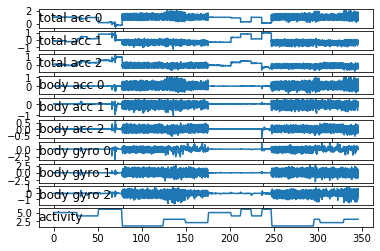

In [18]:
# plot all vars for one subject
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# plot the data for one subject
def plot_subject(X, y):
	pyplot.figure()
	# determine the total number of plots
	n, off = X.shape[2] + 1, 0
	# plot total acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('total acc '+str(i), y=0, loc='left')
		off += 1
	# plot body acc
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body acc '+str(i), y=0, loc='left')
		off += 1
	# plot body gyro
	for i in range(3):
		pyplot.subplot(n, 1, off+1)
		pyplot.plot(to_series(X[:, :, off]))
		pyplot.title('body gyro '+str(i), y=0, loc='left')
		off += 1
	# plot activities
	pyplot.subplot(n, 1, n)
	pyplot.plot(y)
	pyplot.title('activity', y=0, loc='left')
	pyplot.show()

trainX, trainy = load_dataset('train', 'HARDataset/UCI/')
# load mapping of rows to subjects
sub_map = load_file('HARDataset/UCI/train/subject_train.txt')
train_subjects = unique(sub_map)
print(train_subjects)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
print(subX.shape, suby.shape)
width = os.get_terminal_size().columns
print("Line plot for all variables for a single subject".center(width))
# plot data for subject
plot_subject(subX, suby)

Segment to plot Histograms of the total acceleration data by activity

                                Histograms of the total acceleration data by activity                                


/home/navya_ramesh0695/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:74: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


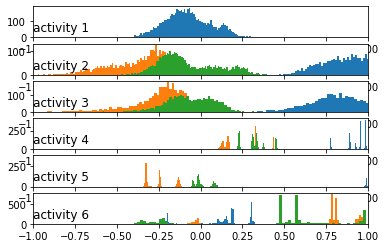

In [20]:
from numpy import array
from numpy import dstack
from numpy import unique
from pandas import read_csv
from matplotlib import pyplot
 
# load a single file as a numpy array
def load_file(filepath):
	dataframe = read_csv(filepath, header=None, delim_whitespace=True)
	return dataframe.values
 
# load a list of files, such as x, y, z data for a given variable
def load_group(filenames, prefix=''):
	loaded = list()
	for name in filenames:
		data = load_file(prefix + name)
		loaded.append(data)
	# stack group so that features are the 3rd dimension
	loaded = dstack(loaded)
	return loaded
 
# load a dataset group, such as train or test
def load_dataset(group, prefix=''):
	filepath = prefix + group + '/Inertial Signals/'
	# load all 9 files as a single array
	filenames = list()
	# total acceleration
	filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
	# body acceleration
	filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
	# body gyroscope
	filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
	# load input data
	X = load_group(filenames, filepath)
	# load class output
	y = load_file(prefix + group + '/y_'+group+'.txt')
	return X, y
 
# get all data for one subject
def data_for_subject(X, y, sub_map, sub_id):
	# get row indexes for the subject id
	ix = [i for i in range(len(sub_map)) if sub_map[i]==sub_id]
	# return the selected samples
	return X[ix, :, :], y[ix]
 
# convert a series of windows to a 1D list
def to_series(windows):
	series = list()
	for window in windows:
		# remove the overlap from the window
		half = int(len(window) / 2) - 1
		for value in window[-half:]:
			series.append(value)
	return series
 
# group data by activity
def data_by_activity(X, y, activities):
	# group windows by activity
	return {a:X[y[:,0]==a, :, :] for a in activities}
 
# plot histograms for each activity for a subject
def plot_activity_histograms(X, y):
	# get a list of unique activities for the subject
	activity_ids = unique(y[:,0])
	# group windows by activity
	grouped = data_by_activity(X, y, activity_ids)
	# plot per activity, histograms for each axis
	pyplot.figure()
	xaxis = None
	for k in range(len(activity_ids)):
		act_id = activity_ids[k]
		# total acceleration
		for i in range(3):
			ax = pyplot.subplot(len(activity_ids), 1, k+1, sharex=xaxis)
			ax.set_xlim(-1,1)
			if k == 0:
				xaxis = ax
			pyplot.hist(to_series(grouped[act_id][:,:,i]), bins=100)
			pyplot.title('activity '+str(act_id), y=0, loc='left')
	pyplot.show()
trainX, trainy = load_dataset('train', 'HARDataset/UCI/')
# load mapping of rows to subjects
sub_map = load_file('HARDataset/UCI/train/subject_train.txt')
train_subjects = unique(sub_map)
# get the data for one subject
sub_id = train_subjects[0]
subX, suby = data_for_subject(trainX, trainy, sub_map, sub_id)
# plot data for subject
width = os.get_terminal_size().columns
print('Histograms of the total acceleration data by activity'.center(width))
plot_activity_histograms(subX, suby)